In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
# image specification
img_cols,img_rows=100,176
nb_frames = 64    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
len(train)

118562

In [5]:
#train
train = train[train["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = validation[validation["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = {}
labels_dict = temp["Label"].to_dict()
len(train)

25025

In [5]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,batch_size):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [6]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 64, 100, 176, 2)


In [7]:
#low resolution network
weight_decay = 0.005
from keras import regularizers
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 46, 84, 8)     408       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 46, 84, 8)     328       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 60, 23, 42, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 60, 19, 38, 32)    6432      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 58, 19, 38, 32)    3104      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 29, 9, 19, 32)     0         
__________

In [6]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "76"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [10]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [11]:
nb_epoch = 100
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(32*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/100
48/48 [==============================] - 159s 3s/step - loss: 10.4776 - acc: 0.2038 - val_loss: 9.4256 - val_acc: 0.3750

Epoch 00001: val_acc improved from -inf to 0.37500, saving model to E:\Jupyter\Project\save_model\working
Epoch 2/100
48/48 [==============================] - 148s 3s/step - loss: 9.3337 - acc: 0.2227 - val_loss: 8.8774 - val_acc: 0.3906

Epoch 00002: val_acc improved from 0.37500 to 0.39062, saving model to E:\Jupyter\Project\save_model\working
Epoch 3/100
48/48 [==============================] - 140s 3s/step - loss: 8.8665 - acc: 0.3379 - val_loss: 8.6196 - val_acc: 0.4531

Epoch 00003: val_acc improved from 0.39062 to 0.45312, saving model to E:\Jupyter\Project\save_model\working
Epoch 4/100
48/48 [==============================] - 134s 3s/step - loss: 8.5899 - acc: 0.3711 - val_loss: 8.2878 - val_acc: 0.5469

Epoch 00004: val_acc improved from 0.45312 to 0.54688, saving model to E:\Jupyter\Project\save_model\working
Epoch 5/100
48/48 [===============


Epoch 00042: val_acc did not improve from 0.89062
Epoch 43/100
48/48 [==============================] - 123s 3s/step - loss: 2.9379 - acc: 0.8333 - val_loss: 3.1400 - val_acc: 0.7969

Epoch 00043: val_acc did not improve from 0.89062
Epoch 44/100
48/48 [==============================] - 123s 3s/step - loss: 2.8850 - acc: 0.8535 - val_loss: 2.9732 - val_acc: 0.8281

Epoch 00044: val_acc did not improve from 0.89062
Epoch 45/100
48/48 [==============================] - 117s 2s/step - loss: 2.8070 - acc: 0.8470 - val_loss: 2.9005 - val_acc: 0.8125

Epoch 00045: val_acc did not improve from 0.89062
Epoch 46/100
48/48 [==============================] - 116s 2s/step - loss: 2.7711 - acc: 0.8379 - val_loss: 2.8124 - val_acc: 0.8750

Epoch 00046: val_acc did not improve from 0.89062
Epoch 47/100
48/48 [==============================] - 120s 3s/step - loss: 2.7178 - acc: 0.8366 - val_loss: 2.5859 - val_acc: 0.8906

Epoch 00047: val_acc did not improve from 0.89062
Epoch 48/100
48/48 [=========

In [12]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

In [13]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""
print(len(training_loss))
print(len(val_loss))
print(len(training_acc))
print(len(val_acc))

100
100
100
100


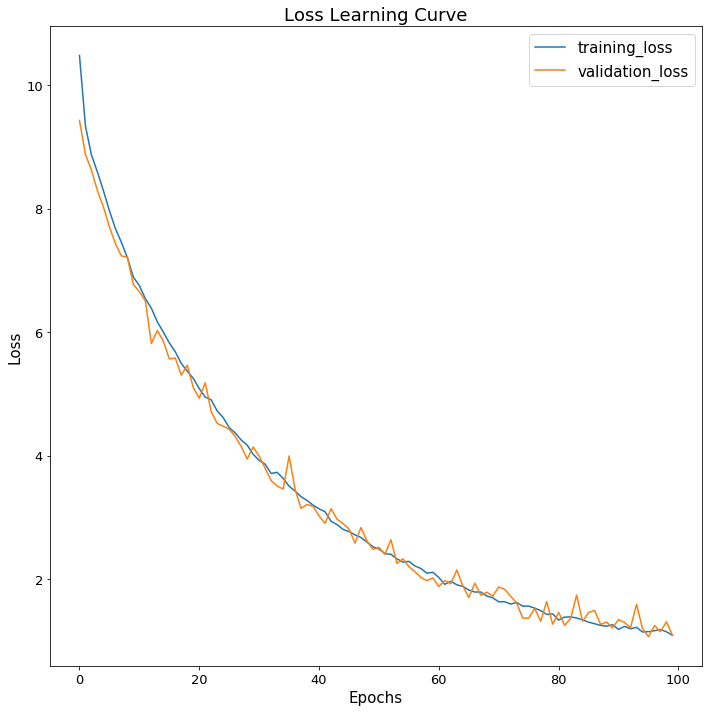

In [18]:
import pickle

with open('E:/Jupyter/Project/save_model/76loss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)
with open('E:/Jupyter/Project/save_model/76loss_val.pkl','rb') as fid:
    val_loss = pickle.load(fid)

plt.figure(figsize=(10, 10))
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Loss Learning Curve",fontsize=18)
plt.legend(loc='best',fontsize=15)
plt.tight_layout()
plt.savefig("Loss.jpg")
plt.show()

with open('E:/Jupyter/Project/save_model/76loss_tr.pkl','wb') as fid:
    pickle.dump(training_loss, fid)
with open('E:/Jupyter/Project/save_model/76loss_val.pkl','wb') as fid:
    pickle.dump(val_loss, fid)

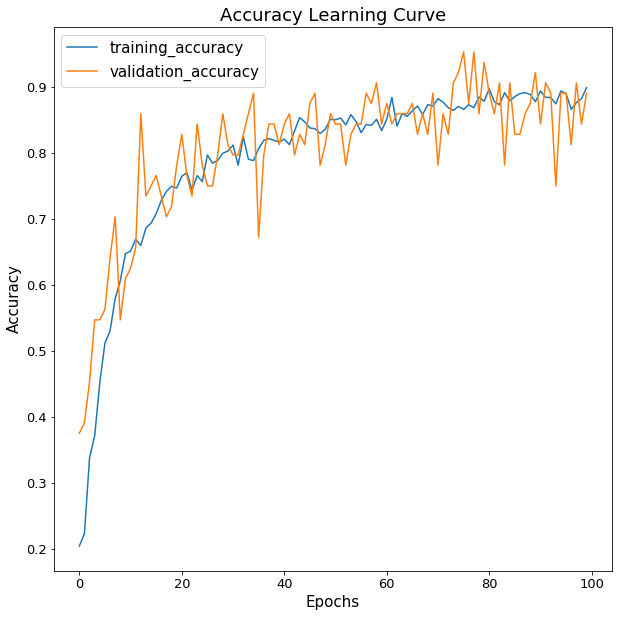

In [19]:
with open('E:/Jupyter/Project/save_model/76acc_tr.pkl','rb') as fid:
    training_acc = pickle.load(fid)
with open('E:/Jupyter/Project/save_model/76acc_val.pkl','rb') as fid:
    val_acc = pickle.load(fid)
    
plt.figure(figsize=(10, 10))
plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Accuracy Learning Curve",fontsize=18)
plt.legend(loc='best',fontsize=15)
plt.savefig("Accuracy.jpg")
plt.show()

with open('E:/Jupyter/Project/save_model/76acc_tr.pkl','wb') as fid:
    pickle.dump(training_acc, fid)
with open('E:/Jupyter/Project/save_model/76acc_val.pkl','wb') as fid:
    pickle.dump(val_acc, fid)

In [7]:
from keras.models import Model, load_model
model1_name = "76"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

In [8]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images_timeSampled")

for vid_ID in tqdm(validation["Video"].tolist()[0:51]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 48.50it/s]


(64, 100, 176, 2)
51


In [19]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[5 3 3 0 5 0 3 5 1 3 0 0 4 2 0 2 4 0 0 2]


In [39]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

[[268   0   0   0   0   0]
 [ 26  14   4 176   6   6]
 [ 28  29  12 189   2   1]
 [162   0   0  90   3   1]
 [ 90   0   0  31 123   1]
 [ 18   0   0  57  68  95]]


In [36]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Benchmark - Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=13, rotation=45)
    plt.yticks(tick_marks, classes,fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

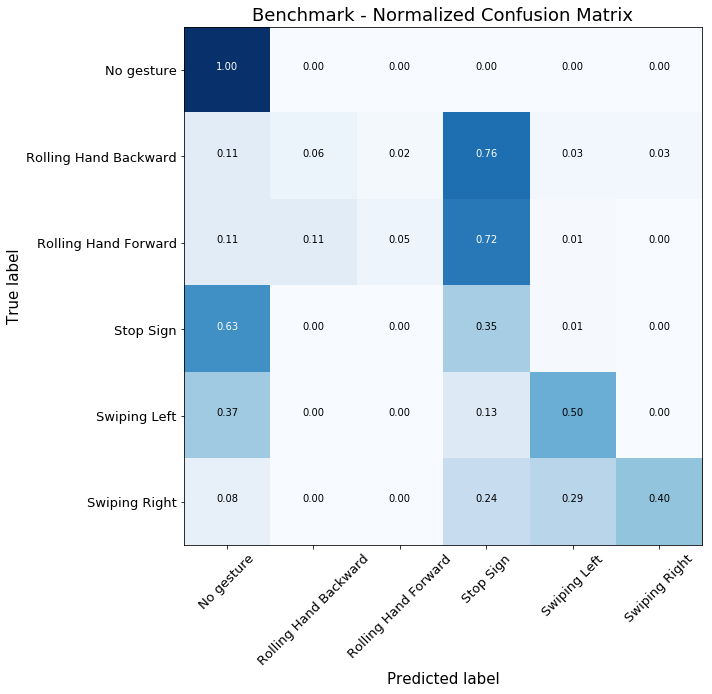

In [40]:
confusion_matrix_plot(met, classes=labels[labels["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])].sort_values(by=['Label'])['Class'].tolist())
plt.tight_layout()
#plt.savefig("nvs1.jpg")

In [23]:
model1.evaluate(train_set,Y_train)

1500/1500 [==============================] - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 51 - ETA: 49 - ETA: 48 - ETA: 46 - ETA: 43 - ETA: 41 - ETA: 39 - ETA: 38 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 28 - ETA: 27 - ETA: 25 - ETA: 23 - ETA: 22 - ETA: 20 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 12 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 74s 50ms/step


[1.8065387131373087, 0.7593333333333333]

In [24]:
model.evaluate(train_set,Y_train)

1500/1500 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 50 - ETA: 48 - ETA: 46 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 41 - ETA: 39 - ETA: 39 - ETA: 37 - ETA: 37 - ETA: 35 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 27 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 17 - ETA: 16 - ETA: 14 - ETA: 12 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - 98s 65ms/step


[1.458736847559611, 0.7426666666666667]

In [9]:
test_pred =model1.predict(train_set[50:51])
import time
start_time=time.time()
result = np.argmax(test_pred, axis =1)
print(time.time()-start_time)
print(result)

0.001001119613647461
[5]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

layer_outputs = [layer.output for layer in model1.layers[:12]]
activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations=activation_model.predict(train_set[50:51])
print(train_set[50:51].shape)
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(train_set[50:51].shape[1]):
    im = plt.imshow(train_set[50:51][0, i, :,:, 0], cmap='viridis')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('input' + '.mp4')

layer_num = 0
layer_names=[]
for layer in model1.layers[:15]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):

    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    print(layer_activation.shape,layer_name)
    if layer_num<10:
        for i in range(layer_activation.shape[1]):
            im = plt.imshow(layer_activation[0, i, :,:, 0], cmap='viridis')
            ims.append([im])
     
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('activation' + str(layer_num) + layer_name + '.mp4')
        layer_num +=1

NameError: name 'model1' is not defined